In [129]:
import pandas as pd
from sqlalchemy import create_engine
import urllib.parse

# Connection Details
SERVER_NAME = 'DESKTOP-33BB6IL'
DATABASE_NAME = 'CustomerDB'
TABLE_NAME = 'Customers'

# Create Engine and Fetch Data
conn_str = urllib.parse.quote_plus(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={SERVER_NAME};"
    f"DATABASE={DATABASE_NAME};"
    f"Trusted_Connection=yes;"
)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={conn_str}")

# Fetch data directly into a DataFrame
df = pd.read_sql(f"SELECT * FROM [{TABLE_NAME}]", engine)

In [130]:
# Get a summary of the DataFrame including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25953 entries, 0 to 25952
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    25953 non-null  object        
 1   InvoiceDate  25953 non-null  datetime64[ns]
 2   CustomerID   22229 non-null  float64       
 3   Country      25953 non-null  object        
 4   Quantity     25953 non-null  int64         
 5   Amount       25953 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.2+ MB


In [131]:
# Get descriptive statistics for numerical columns
df.describe()

,InvoiceDate,CustomerID,Quantity
count,25953,22229.000000,25953.000000
mean,2021-06-27 02:12:28.607097600,15238.289892,199.474049
min,2020-12-01 08:26:00,12346.000000,-80995.000000
25%,2021-03-27 12:36:00,13755.000000,6.000000
50%,2021-07-04 15:46:00,15136.000000,100.000000
75%,2021-10-07 14:04:00,16746.000000,240.000000
max,2021-12-09 12:50:00,18287.000000,80995.000000
std,NaN,1732.981685,1107.075809


In [132]:
# Check for the total number of missing values in each column
df.isnull().sum()

InvoiceNo         0
InvoiceDate       0
CustomerID     3724
Country           0
Quantity          0
Amount            0
dtype: int64

In [133]:
# ===== Data Cleaning =====

In [134]:
# Remove rows are none
df.dropna(inplace=True)

In [135]:
# Remove any duplicate rows
df.drop_duplicates(inplace=True)

In [136]:
# Remove rows where CustomerID is missing
df.dropna(subset=['CustomerID'], inplace=True)

In [137]:
# Correct the data types for columns
df['Amount'] = df['Amount'].str.replace(',', '.').astype(float)
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [140]:
# Remove returns or canceled orders (where Quantity is zero or negative)
df = df[df['Quantity'] > 0]

In [144]:
# ===== Exploratory Data Analysis (EDA) & Outlier Detection =====

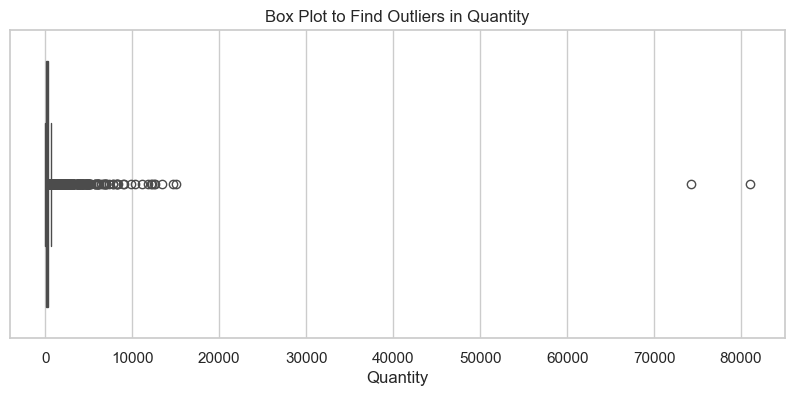

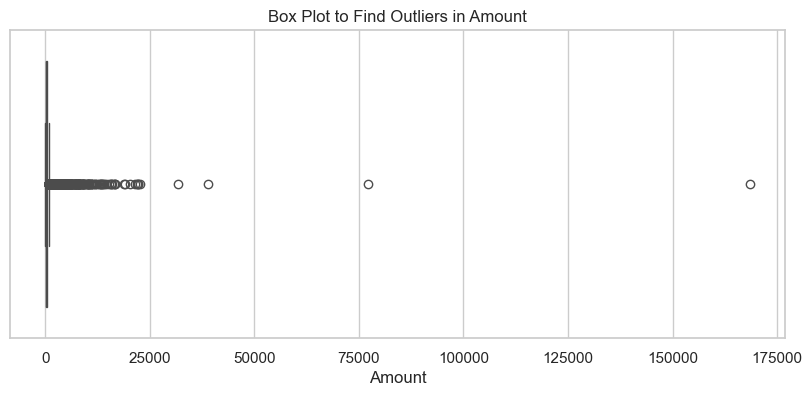

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box Plot for Quantity 
plt.figure(figsize=(10, 4)) 
sns.boxplot(x=df['Quantity'])
plt.title('Box Plot to Find Outliers in Quantity')
plt.show()

# Box Plot for Amount
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Amount'])
plt.title('Box Plot to Find Outliers in Amount')
plt.show()

In [150]:
# Customer Segmentation (Value-Based using IQR)

# Calculate IQR to define a threshold for "VIP" customers
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR


# Split customers into "Normal" and "VIP" based on the IQR threshold
df_vip_customers = df[df['Amount'] > upper_bound]
df_normal_customers = df[df['Amount'] <= upper_bound]

print("--- Customer Segmentation Results ---")
print(f"Total Invoices: {df.shape[0]}")
print("-------------------------------------")
print(f"Normal Customers' Invoices: {df_normal_customers.shape[0]}")
print(f"VIP Customers' Invoices (Outliers): {df_vip_customers.shape[0]}")
print("-------------------------------------")
print(f"Upper Bound for 'Normal' Invoice Amount: {upper_bound:.2f}")

--- Customer Segmentation Results ---
Total Invoices: 18566
-------------------------------------
Normal Customers' Invoices: 17098
VIP Customers' Invoices (Outliers): 1468
-------------------------------------
Upper Bound for 'Normal' Invoice Amount: 941.38


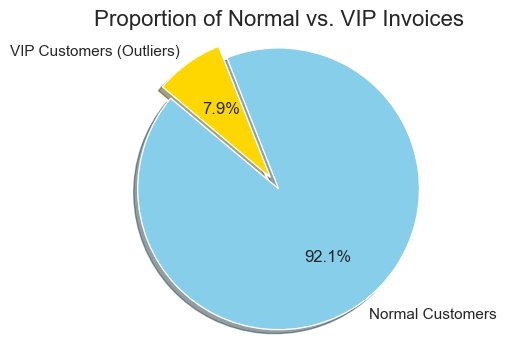

In [153]:
import matplotlib.pyplot as plt

# Get the counts for each segment
normal_count = df_normal_customers.shape[0]
vip_count = df_vip_customers.shape[0]

# Prepare the data for the pie chart
labels = ['Normal Customers', 'VIP Customers (Outliers)']
sizes = [normal_count, vip_count]
colors = ['skyblue', 'gold']
explode = (0, 0.1)

# Create the pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Proportion of Normal vs. VIP Invoices', fontsize=16)
plt.axis('equal')
plt.show()

In [155]:
# ==== RFM Analysis ====

In [157]:
from datetime import timedelta
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

# Group by customer and calculate Recency, Frequency, and Monetary values
rfm_data = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # Recency
    'InvoiceNo': 'nunique',                                        # Frequency
    'Amount': 'sum'                                                # Monetary
})

# Rename columns for clarity
rfm_data.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'Amount': 'Monetary'}, inplace=True)


In [161]:
# Recency Score
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], q=4, labels=[4, 3, 2, 1])

# Frequency & Monetary Scores
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'].rank(method='first'), q=4, labels=[1, 2, 3, 4])


rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)

In [164]:
# Define the segmentation dictionary
segment_map = {
    r'[3-4][3-4][3-4]': 'Champions',
    r'[3-4][1-2][3-4]': 'New Potential Customers',
    r'[3-4][1-4][1-2]': 'Low-Value Customers',
    r'2[3-4][3-4]': 'Potential Loyalists',
    r'1[3-4][3-4]': 'At-Risk Customers',
    r'1[1-2][1-4]': 'Hibernating Customers',
    r'2[1-2][1-4]': 'Need Attention'
}

#  Apply the dictionary to the correct RFM_Score column 
rfm_data['Segment'] = rfm_data['RFM_Score'].replace(segment_map, regex=True)

# --- Step 3: Assign a default segment for any customer that doesn't match the rules ---
rfm_data['Segment'] = rfm_data['Segment'].apply(lambda x: 'Others' if x.isdigit() else x)

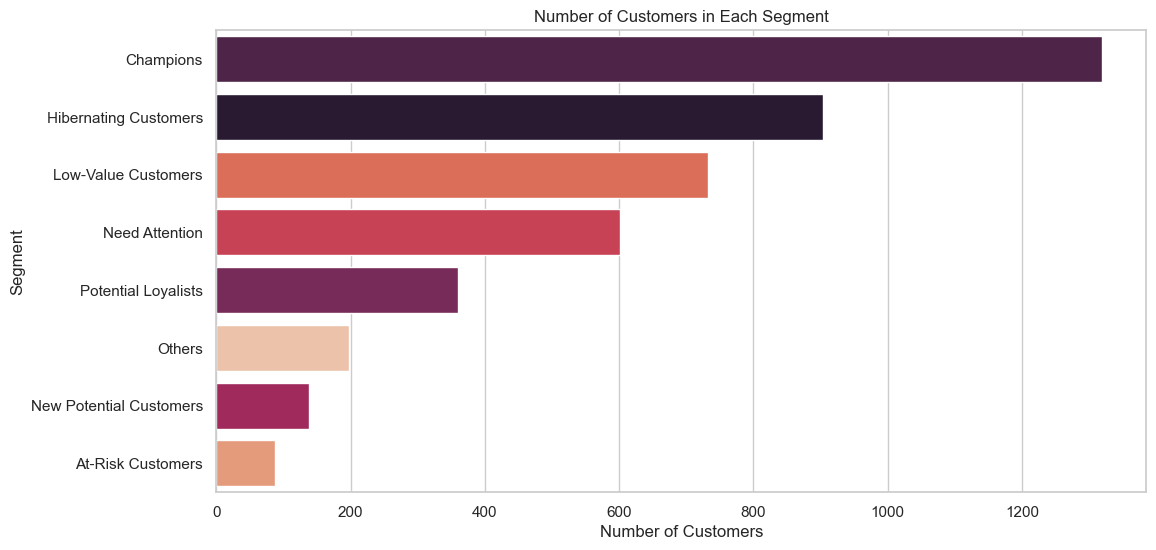

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Create the bar chart using the updated syntax
sns.countplot(
    y=rfm_data['Segment'],
    order=rfm_data['Segment'].value_counts().index,
    hue=rfm_data['Segment'], 
    palette='rocket',
    legend=False             
)

# Add titles and labels for clarity
plt.title('Number of Customers in Each Segment')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()